In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/frostace/.conda/envs/bert_env/lib

Tensor Flow Version: 1.13.1
Keras Version: 2.2.4-tf

Python 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 1.0.1
Scikit-Learn 0.22.1
GPU is NOT AVAILABLE


In [2]:
stock_data_df = pd.read_csv('GOOG.csv')

In [3]:
stock_data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-02-06,1139.569946,1147.000000,1112.770020,1115.229980,1115.229980,2105600
1,2019-02-07,1104.160034,1104.839966,1086.000000,1098.709961,1098.709961,2044800
2,2019-02-08,1087.000000,1098.910034,1086.550049,1095.060059,1095.060059,1075800
3,2019-02-11,1096.949951,1105.944946,1092.859985,1095.010010,1095.010010,1065200
4,2019-02-12,1106.800049,1125.295044,1105.849976,1121.369995,1121.369995,1609100


In [4]:
dates = stock_data_df.loc[:, 'Date'].to_list()
close_prices = stock_data_df.loc[:, 'Adj Close'].to_list()
volumes = stock_data_df.loc[:, 'Volume'].to_list()

- stock price feature fields:
    - Date
    - Past N price
    - Past N - 1 price
    - ...
    - Past 1 price
    - Label

In [6]:
time_window = 3

In [7]:
def stock_price_feature_label_generator(time_window = 3):
    if time_window <= 0: 
        raise ValueError("argument time_window has to be at least 1")
    # use "time_window" previous days to predict the movement of the next day
    label = [-1] + [1 if close_prices[i] > close_prices[i - 1] else 0 for i in range(1, len(close_prices))]
    result = pd.DataFrame(dates[time_window: ], columns = ['Date'])
    result.insert(loc=result.shape[1], column="Label", value=label[time_window: ])
    for i in range(time_window):
        result.insert(loc=result.shape[1], column="Past " + str(time_window - i) + " Day Adj. Price", value=np.divide(close_prices[i: len(close_prices) - time_window + i], volumes[i: len(volumes) - time_window + i]))
#     for i in range(time_window):
#         result.insert(loc=result.shape[1], column="Past " + str(time_window - i) + " Day Price", value=close_prices[i: len(close_prices) - time_window + i])
#     for i in range(time_window):
#         result.insert(loc=result.shape[1], column="Past " + str(time_window - i) + " Volume", value=volumes[i: len(volumes) - time_window + i])
    return result

In [8]:
stock_price_feature = stock_price_feature_label_generator(time_window)

In [9]:
stock_price_feature.head()

,Date,Label,Past 3 Day Adj. Price,Past 2 Day Adj. Price,Past 1 Day Adj. Price
0,2019-02-11,0,0.000530,0.000537,0.001018
1,2019-02-12,1,0.000537,0.001018,0.001028
2,2019-02-13,0,0.001018,0.001028,0.000697
3,2019-02-14,1,0.001028,0.000697,0.001067
4,2019-02-15,0,0.000697,0.001067,0.001184


In [10]:
only_date_and_label = stock_price_feature_label_generator(1).drop(columns=['Past 1 Day Adj. Price'])

In [11]:
only_date_and_label.head()

,Date,Label
0,2019-02-07,0
1,2019-02-08,0
2,2019-02-11,0
3,2019-02-12,1
4,2019-02-13,0


In [12]:
aggregated_vector = pd.read_csv("aggregated_vector.csv")

In [13]:
aggregated_vector.shape

(366, 797)

In [14]:
only_date_and_label.shape

(252, 2)

In [15]:
merged_feature = only_date_and_label.merge(aggregated_vector, left_on="Date", right_on="Date")

In [16]:
# merged_feature = merged_feature.drop(columns=['date'])

In [17]:
merged_feature

,Date,Label,0,1,2,3,4,5,6,7,...,num_pos_VB,num_pos_NN,num_neg_JJ,num_neg_RB,num_neg_VB,num_neg_NN,total_score_JJ,total_score_RB,total_score_VB,total_score_NN
0,2019-02-07,0,44.812154,-81.759171,208.085356,-15.435892,139.442979,-85.841596,-28.383232,221.925643,...,6.933314,3.260692,92.941955,25.452681,5.010890,35.102889,24.031710,12.909980,2.539479,-3.695849
1,2019-02-08,0,66.556864,-55.485937,151.719538,-9.212200,130.066540,-70.200329,-30.366276,190.425124,...,8.025492,11.202800,34.647003,0.000000,4.246516,38.121294,16.613835,4.651010,1.154680,-2.716154
2,2019-02-11,0,58.641162,-44.304634,159.504643,-27.267690,130.301508,-81.620357,-23.481772,149.123745,...,1.343559,12.117383,12.827125,10.304466,0.000000,34.485655,32.494622,3.788900,1.074847,-3.429315
3,2019-02-12,1,113.849806,-152.483263,478.352417,1.053882,306.070730,-223.821995,-50.552317,410.709477,...,16.665804,1.000000,234.703298,4.000000,1.000000,13.000000,24.042424,31.872133,6.466322,-2.083333
4,2019-02-13,0,54.801063,-57.812219,213.430908,-14.304793,160.358078,-70.627481,-48.408083,163.612712,...,0.000000,13.187751,34.011516,6.691450,0.000000,37.825079,36.128968,8.694767,0.000000,0.678999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020-01-31,0,79.060236,-90.148327,282.224408,-23.073448,179.776425,-132.129005,-9.530316,258.054390,...,1.258245,21.507597,32.551502,24.678625,0.000000,67.958802,43.600521,4.803653,0.503298,-1.392404
248,2020-02-03,1,405.235422,-350.571936,1302.173015,22.137354,724.729243,-265.601971,-208.154065,1159.927739,...,2.000000,112.141398,699.083964,39.913999,1.000000,25.000000,12.129913,31.345564,0.716667,61.168499
249,2020-02-04,0,255.790100,-290.758383,918.488345,48.411741,404.169472,-337.208945,-173.181101,826.260365,...,18.659558,36.284565,405.341309,124.967059,2.000000,155.861510,-50.111467,-30.351829,14.125723,-89.583564
250,2020-02-05,1,53.959203,-65.196927,242.149157,-13.960206,149.707033,-67.129872,-30.039788,213.583897,...,2.605151,4.982858,34.397965,28.588687,6.239696,17.856494,56.221531,0.241561,0.054636,-3.766671


In [18]:
vector_by_day = merged_feature.iloc[:, 2:].to_numpy()

In [19]:
# regenerate feature with time window

feature_by_date = pd.DataFrame(columns=aggregated_vector.columns)

for i in range(len(vector_by_day)-1, time_window, -1):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("Generating: %.02f" % ((len(vector_by_day) - 1 - i) / (len(vector_by_day) - 1 - time_window) * 100))
    sys.stdout.flush()
    
    prev_N_days_sum_vector = np.array([0 for i in range(aggregated_vector.shape[1] - 1)])
    
    # sum up
    for delta in range(1, 1 + time_window):
        prev_N_days_sum_vector = np.add(prev_N_days_sum_vector, vector_by_day[i - delta])
    
    # normalize
#     prev_N_days_sum_vector = prev_N_days_sum_vector / np.linalg.norm(prev_N_days_sum_vector)
    
    # add date
    feature_with_date = np.concatenate((np.array([merged_feature.iloc[i, 0]]), prev_N_days_sum_vector))
    new_row_df = pd.DataFrame(feature_with_date).transpose()
    new_row_df.columns = aggregated_vector.columns
    
    
    # insert row
    feature_by_date = pd.concat([new_row_df, feature_by_date], ignore_index=True)

Testing: 99.60

In [20]:
feature_by_date

,Date,0,1,2,3,4,5,6,7,8,...,num_pos_VB,num_pos_NN,num_neg_JJ,num_neg_RB,num_neg_VB,num_neg_NN,total_score_JJ,total_score_RB,total_score_VB,total_score_NN
0,2019-02-13,239.04783314998406,-252.27383333963655,789.5765987517749,-35.42600826018949,566.4387777182092,-375.6426814845533,-104.40036517751003,750.2583461473796,-296.7817512463623,...,26.034854513783998,24.320183104822547,282.1774261731119,14.30446579113303,5.246516380728746,85.60694873699563,73.15088083372066,40.31204280836647,8.695848137810996,-8.228802131936638
1,2019-02-14,227.2920318425851,-254.60011579540407,851.2879688093806,-40.51860112676501,596.7303157429169,-376.06983361806857,-122.4421724774944,723.4459339641905,-291.6576390619857,...,18.00936238269962,26.3051339779625,281.54193910659853,20.99591548807852,1.0,85.31073336077944,92.66601343696509,44.35580020087662,7.541168374697935,-4.8336491627515885
2,2019-02-15,226.3212123184711,-262.33922019188685,889.7889853008476,-19.547306823073484,607.6731549578997,-372.40253773811423,-136.55857501044616,755.7294713844562,-299.7924673407923,...,19.141236357634202,15.187750765573526,315.8020588157578,15.882841697781089,1.0,77.55746326283969,90.3806737228923,41.56334532522477,7.7040377959516615,-7.092012925831106
3,2019-02-19,166.14543963186344,-150.78216768278307,574.8610029947415,-30.388147609450925,418.43006201513583,-226.75512891926695,-112.46381274775277,507.2590862237299,-173.59583826910975,...,2.475432528979796,22.051938508601317,118.7823711769343,31.90237724342521,0.0,100.39576247270017,78.97974423442164,10.729937227011838,1.2377162644898978,-7.809155064565822
4,2019-02-20,144.39971164470603,-130.55251648751016,507.0079802616093,-20.214566988966347,363.17328197898814,-215.73623468117876,-90.30689760425446,503.0861382624948,-170.14042196875573,...,2.475432528979796,17.41457793079588,120.64750328355981,28.74249369860073,0.0,73.3645013415086,62.25891664547484,3.0270474101747924,1.2377162644898978,-4.77478925497639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2020-01-31,210.4255391262887,-223.99831932654007,824.5984787289016,-74.55085289710956,502.3381619966607,-336.0957242254475,-94.06028433444692,790.7756027026605,-400.2601337722882,...,14.981951927803877,43.46939752180924,364.4989508921102,27.62737443469871,4.916279300415866,247.87046615712137,4.221319800703439,22.283762726336057,10.166301989873222,-38.59187995323583
244,2020-02-03,226.52768640270205,-259.05477079960485,933.7772218504904,-86.32519540183458,555.8782993997776,-385.0069613068283,-87.76455953368031,873.855787748751,-444.981504020844,...,16.24019688892043,49.72446731829193,360.56708984287155,50.30599968164454,4.916279300415866,270.1105567429304,37.147155468839514,21.110592221596857,10.669599974319842,-36.63594768013703
245,2020-02-04,579.4419020139817,-541.5898423382158,2001.7962830778981,-47.69275716815875,1140.9617507777089,-535.3911483108517,-275.5397998870887,1808.907301254369,-1074.2729327375093,...,15.162044931090144,155.24368285729645,1002.8692029350831,69.59262455674424,2.0,236.77787997288152,28.826444960486025,56.77031878968333,10.04300462709216,38.33486019361001
246,2020-02-05,740.0857577010445,-731.4786467935655,2502.8857688883554,47.475647450994515,1308.6751396414747,-734.9399211515631,-390.8654820861185,2244.242494443514,-1292.2008995811993,...,21.917802713514156,169.93356028646045,1136.9767736956828,189.55968352230053,3.0,248.82031118113082,5.618967421008932,5.797387658829338,15.345687776108294,-29.807469194562717


- fusion with prev price and volume

In [21]:
fused_feature = stock_price_feature.merge(feature_by_date, left_on="Date", right_on="Date")

- check imbalance

In [22]:
np.count_nonzero(fused_feature.Label.to_list()) / len(fused_feature)

0.5524193548387096

In [24]:
fused_feature.head()

,Date,Label,Past 3 Day Adj. Price,Past 2 Day Adj. Price,Past 1 Day Adj. Price,0,1,2,3,4,...,num_pos_VB,num_pos_NN,num_neg_JJ,num_neg_RB,num_neg_VB,num_neg_NN,total_score_JJ,total_score_RB,total_score_VB,total_score_NN
0,2019-02-13,0,0.001018,0.001028,0.000697,239.04783314998406,-252.27383333963655,789.5765987517749,-35.42600826018949,566.4387777182092,...,26.034854513783998,24.320183104822547,282.1774261731119,14.30446579113303,5.246516380728746,85.60694873699563,73.15088083372066,40.31204280836647,8.695848137810996,-8.228802131936638
1,2019-02-14,1,0.001028,0.000697,0.001067,227.2920318425851,-254.60011579540407,851.2879688093806,-40.51860112676501,596.7303157429169,...,18.00936238269962,26.3051339779625,281.54193910659853,20.99591548807852,1.0,85.31073336077944,92.66601343696509,44.35580020087662,7.541168374697935,-4.8336491627515885
2,2019-02-15,0,0.000697,0.001067,0.001184,226.3212123184711,-262.33922019188685,889.7889853008476,-19.547306823073484,607.6731549578997,...,19.141236357634202,15.187750765573526,315.8020588157578,15.882841697781089,1.0,77.55746326283969,90.3806737228923,41.56334532522477,7.7040377959516615,-7.092012925831106
3,2019-02-19,1,0.001067,0.001184,0.000768,166.14543963186344,-150.78216768278307,574.8610029947415,-30.388147609450925,418.43006201513583,...,2.475432528979796,22.051938508601317,118.7823711769343,31.90237724342521,0.0,100.39576247270017,78.97974423442164,10.729937227011838,1.2377162644898978,-7.809155064565822
4,2019-02-20,0,0.001184,0.000768,0.001069,144.39971164470603,-130.55251648751016,507.0079802616093,-20.214566988966347,363.17328197898814,...,2.475432528979796,17.41457793079588,120.64750328355981,28.74249369860073,0.0,73.3645013415086,62.25891664547484,3.0270474101747924,1.2377162644898978,-4.77478925497639


- import ML lib

In [25]:
# from bert_serving.client import BertClient
import math
from string import punctuation
import matplotlib.pyplot as plt
import re
import os
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import SVC
import xgboost as xgb

# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif

/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [26]:
fused_feature.iloc[:, 1:].shape

(248, 800)

                    Specs      Score
422,
235,
152,
254,
481,
700,
637,
611,
92 ,
365,
115,
131,
207,
619,
71 ,
0  ,
799,
114,
555,
795,
645,
42 ,
557,
153,
780

In [71]:
feature.corrwith(fused_feature.iloc[:, [422,
                                        235,
                                        152,
                                        254,
                                        481,
                                        700,
                                        637,
                                        611,
                                        92 ,
                                        365,
                                        115,
                                        131,
                                        207,
                                        619,
                                        71 ,
                                        0  ,
                                        799,
                                        114,
                                        555,
                                        795,
                                        645,
                                        42 ,
                                        557,
                                        153,
                                        780]], axis=0)

Label                   NaN
Past 1 Day Adj. Price   NaN
Past 2 Day Adj. Price   NaN
Past 3 Day Adj. Price   NaN
Past 4 Day Adj. Price   NaN
Past 5 Day Adj. Price   NaN
dtype: float64

'# get correlations of each features in dataset\ncorrmat = fused_feature.iloc[:, 1:].corr()\ntop_corr_features = corrmat.index\nplt.figure(figsize=(20, 20))\n# plot heat map\ng = sns.heatmap(fused_feature[top_corr_features].corr(), annot=True, cmap="RdYlGn")'

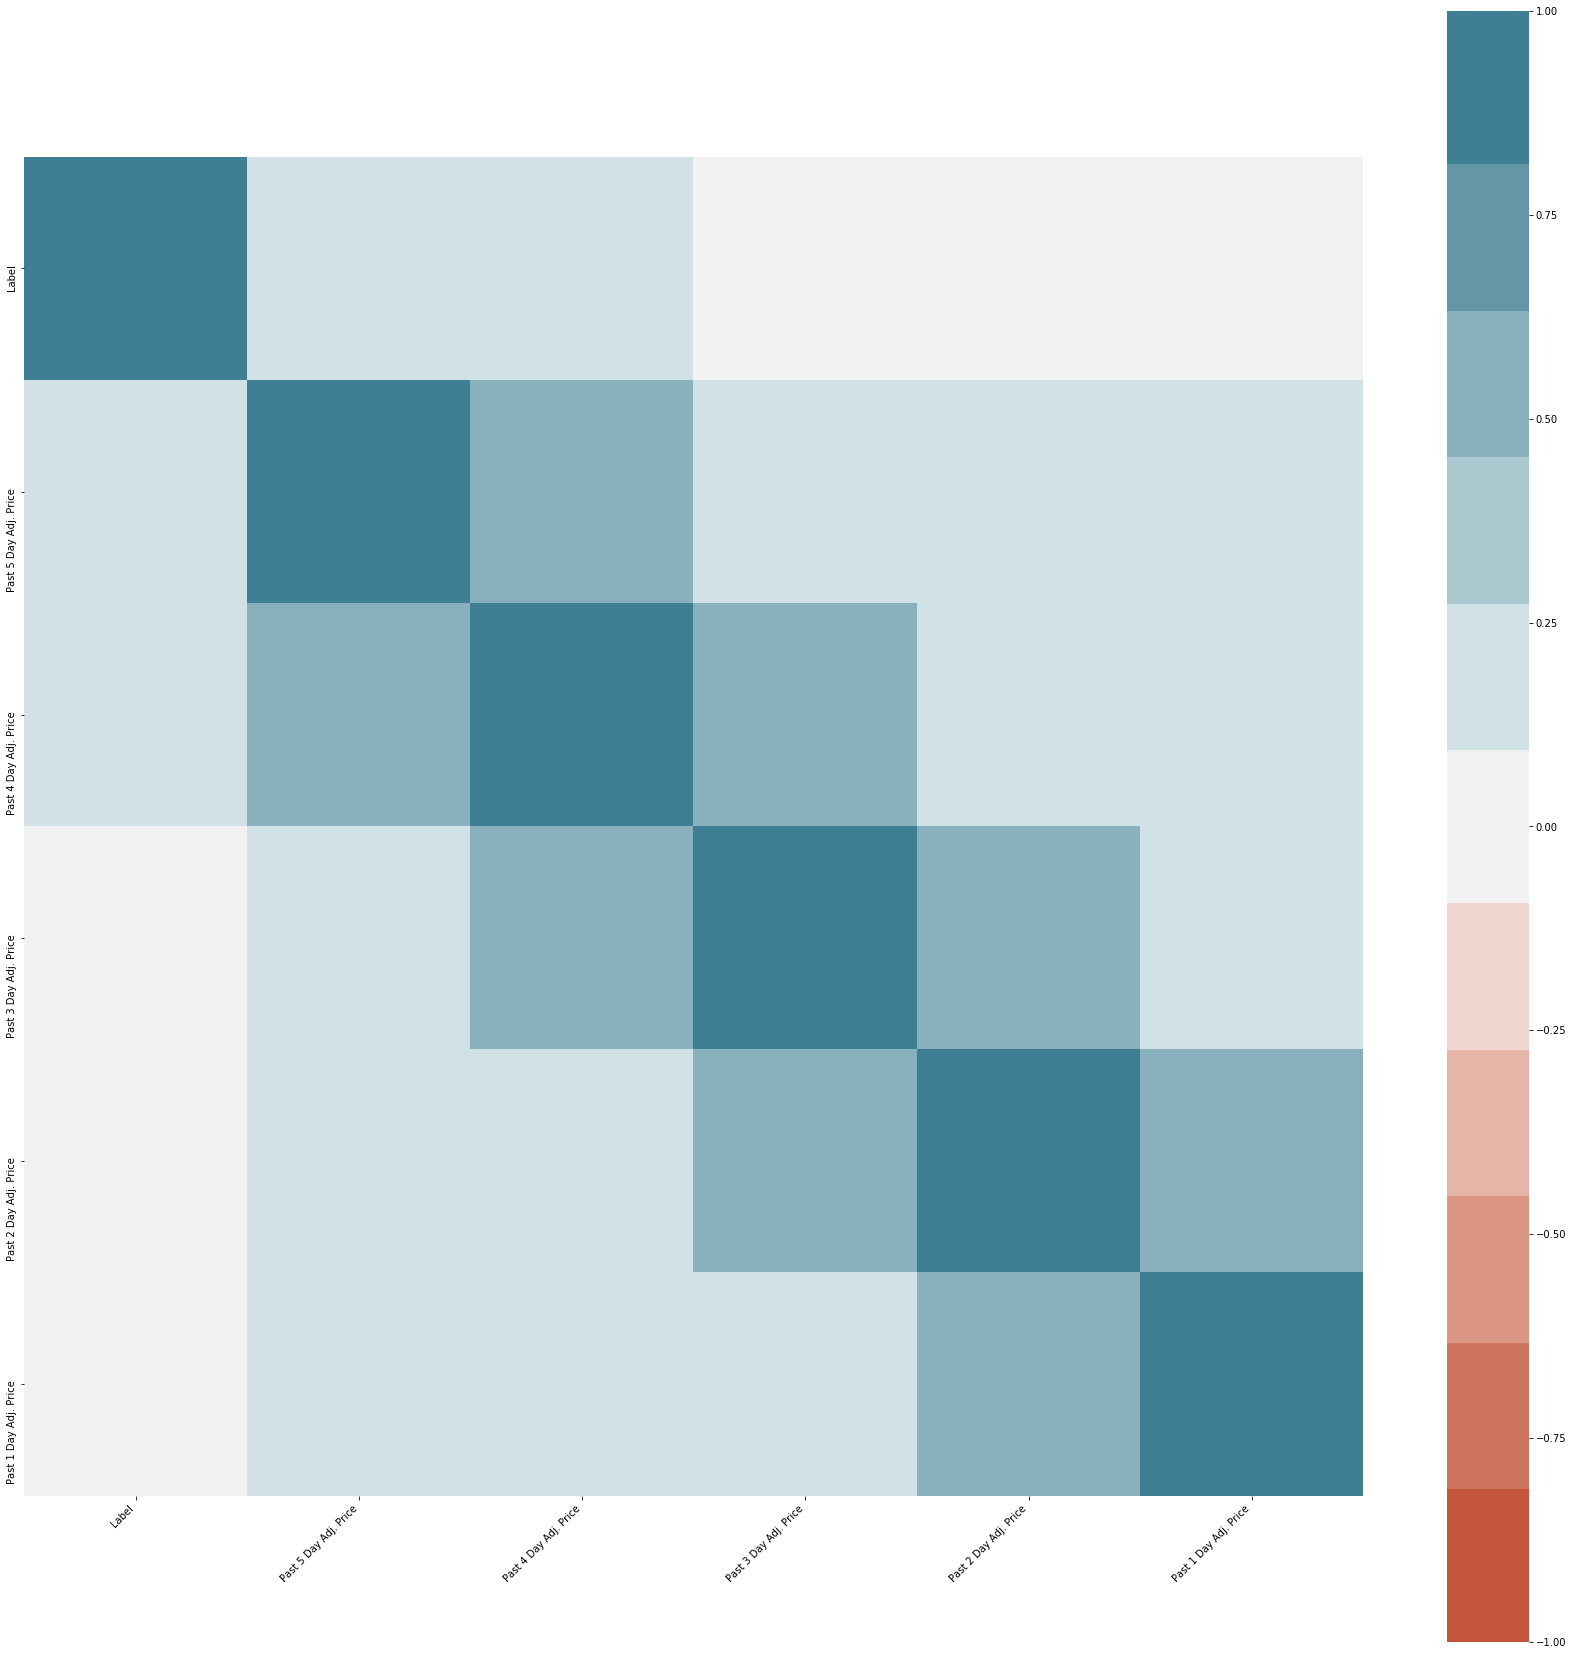

In [70]:
import seaborn as sns

# get first 20 dimensions from the 768-dimensional vector
feature = fused_feature.iloc[:, 1:21]
corr = feature.corr()
_ = plt.figure(figsize=(30, 30))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=11), # better if the palette color num is odd
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
'''# get correlations of each features in dataset
corrmat = fused_feature.iloc[:, 1:].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
# plot heat map
g = sns.heatmap(fused_feature[top_corr_features].corr(), annot=True, cmap="RdYlGn")'''

- feature selection

In [27]:
# apply SelectKBest class to extract top 10 best features
X = fused_feature.iloc[:, 2:]
y = fused_feature.Label
bestfeatures = SelectKBest(score_func=f_classif, k=25)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  # naming the dataframe columns
print(featureScores.nlargest(25, 'Score'))  # print 10 best features

          Specs      Score
698         695  11.620554
420         417   8.111237
635         632   6.897168
337         334   5.993560
536         533   5.733724
203         200   5.432642
205         202   5.264914
790  num_pos_NN   5.173040
422         419   5.109629
792  num_neg_RB   4.952683
704         701   4.837432
479         476   4.696856
54           51   4.633841
233         230   4.589296
90           87   4.458117
517         514   4.118683
342         339   3.894224
154         151   3.724229
661         658   3.610248
489         486   3.564808
241         238   3.559202
252         249   3.467280
609         606   3.432648
386         383   3.431401
140         137   3.396689


/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [776] are constant.
  UserWarning)
/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [38]:
X = fused_feature.iloc[:, [ 700,
                            422,
                            637,
                            339,
                            538,
                            205,
                            207,
                            792,
                            424,
                            794,
                            706,
                            481,
                            56 ,
                            235,
                            92 ,
                            519,
                            344,
                            156,
                            663,
                            490,
                            243,
                            254,
                            611,
                            388,
                            142]]
y = fused_feature.Label.to_list()

In [43]:
X = X.replace('NAN', np.nan)

In [45]:
X.div(X.sum(axis=1), axis=0)

AssertionError: <class 'pandas.core.series.Series'>

- train test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
xgb_model = xgb.XGBClassifier(learning_rate=0.03,
                                n_estimators=600,
                                max_depth=7,
                                min_child_weight=5,
                                gamma=0,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                objective='binary:logistic',
                                nthread=4,
                                scale_pos_weight=1,
                                seed=27)
xgb_model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields 695, 417, 632, 334, 533, 200, 202, num_pos_NN, 419, num_neg_RB, 701, 476, 51, 230, 87, 514, 339, 151, 658, 485, 238, 249, 606, 383, 137

In [82]:
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:,1]

In [84]:
print("\nModel Report")
print("Accuracy : %.4g" % accuracy_score(y_test, y_pred))
print("AUC Score (Train): %f" % roc_auc_score(y_test, y_pred_prob))


Model Report
Accuracy : 0.5366
AUC Score (Train): 0.579167
